In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from cv import Cadence
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import ReLU, Conv2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from ignite.metrics import Recall, Precision, Accuracy
from sklearn.model_selection import train_test_split

In [9]:
torch.cuda.empty_cache()

### Config

In [10]:
conf_dict = {
    "batch_size": 32,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 20,

    "transfer_model_name": "efficientnet_b0", #"tf_efficientnet_b5_ns", #

    "train_dir": "../data/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../data/test/",
    "test_csv": "sample_submission.csv",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "use_all",
        "only_1": "only_1",
        "50_50": "50_50",
        "weighted": "weighted",
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Custom Dataset

In [11]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, img_dir, test=False, transform=None, target_transform=None, use_cv_preprocessing=False):
		self.test = test
		if not self.test:
			self.img_labels = pd.read_csv(img_dir + conf_dict["train_csv"])
		else:
			self.img_labels = pd.read_csv(img_dir + conf_dict["test_csv"])
		self.img_labels['file_path'] = self.img_labels['id'].apply(self.get_file_path, dir=img_dir)
		self.img_dir = img_dir
		self.file_names = self.img_labels['file_path'].values
		self.transform = transform
		self.target_transform = target_transform
		self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.img_labels)

		# testing with single batch - for example with 1k epochs
		# return conf_dict["batch_size"]

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		# if self.use_cv_preprocessing:
		# 	cadence = Cadence(file_path)
		# 	cadence.cv()

		image = np.vstack(image).T

		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()

		label = torch.tensor(self.img_labels["target"][idx]).float()

		image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label

	def get_file_path(self, image_id, dir):
		return dir + "{}/{}.npy".format(image_id[0], image_id)


In [12]:
network_conf_dict = {
    "conv_1_filter_output": 8,
    "conv_2_filter_output": 16,
    "conv_3_filter_output": 16,
}

class NeuralNetwork(nn.Module):
    def __init__(self):
        print("initializing custom network")
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(network_conf_dict["conv_3_filter_output"] * 64 * 64, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 1),
        )
        self.simple_cnn_stack = nn.Sequential(
            Conv2d(3, network_conf_dict["conv_1_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_1_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(network_conf_dict["conv_1_filter_output"], network_conf_dict["conv_2_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_2_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(network_conf_dict["conv_2_filter_output"], network_conf_dict["conv_3_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_3_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.simple_cnn_stack(x)
        x = self.flatten(x)
        x = self.dropout(x)
        logits = self.linear_relu_stack(x)
        return logits

class NeuralNetworkWithBackbone(nn.Module):
    def __init__(self, pretrained=False):
        print("initializing transfer learning network")
        super().__init__()
        self.backbone = timm.create_model(conf_dict["transfer_model_name"], pretrained=pretrained, in_chans=1)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 1)
        # self.backbone = models.resnet50(pretrained=pretrained).to(device)
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
            
        # self.backbone.fc = nn.Sequential(
        #             nn.Linear(2048, 128),
        #             nn.ReLU(inplace=True),
        #             nn.Linear(128, 1)).to(device)

    def forward(self, x):
        return self.backbone(x)


In [13]:
class SETITrainValidation():
    def __init__(self, train_dir, test_dir, load_model=False, val_split=0.25, use_backbone=True):
        self.dataset_whole_train = SETIDataset(train_dir, transform=self.get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
        self.dataset_whole_val = SETIDataset(train_dir, transform=self.get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf
        # self.dataset_test = SETIDataset(test_dir, test=True, transform=self.get_transforms(data="test"), use_cv_preprocessing=True)
        if load_model:
            self.model = self.load_model(use_backbone)
        else:
            self.model = self.new_model(use_backbone)
        self.loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() => needs sigmoid as activation function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(self.model.parameters(), lr=conf_dict["learn_rate"]) 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
        )

        self.val_split = val_split
        self.train_dataloader = None
        self.val_dataloader = None
        self.train_losses = []
        self.train_acc = []
        self.val_losses = []
        self.val_acc = []
        self.accuracy = Accuracy()
        self.precision = Precision()
        self.recall = Recall()


    def get_transforms(self, data):
        if data == 'train':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                ToTensorV2(),
            ])
        elif data == 'val' or data == 'test':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                ToTensorV2(),
            ])

    def split(self, behaviour="all", use_all=True):
        dataset_whole_size = len(self.dataset_whole_train)
        if use_all:
            val_range = int(np.floor(self.val_split * dataset_whole_size))
            train_range = dataset_whole_size - val_range
            train_set, val_set = torch.utils.data.random_split(self.dataset_whole_train, [train_range, val_range])
        else:
            val_range = int(np.floor(self.val_split * conf_dict["only_use"]))
            train_range = conf_dict["only_use"] - val_range
            small_dataset_train = Subset(self.dataset_whole_train, np.random.randint(dataset_whole_size, size=conf_dict["only_use"]))
            train_set, val_set = torch.utils.data.random_split(small_dataset_train, [train_range, val_range])

        if behaviour == conf_dict["behaviours"]["only_1"]:
            print("Using only 1 labeled data...")
            train_indices_1_labels = [train_set.indices[i] for i in range(len(train_set)) if self.dataset_whole_train.img_labels["target"][train_set.indices[i]] == 1]
            train_sampler = SubsetRandomSampler(train_indices_1_labels)
            self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
        if behaviour == conf_dict["behaviours"]["50_50"]:
            print("Using 50/50 data...")
            train_indices_1_labels = np.array([train_set.indices[i] for i in range(len(train_set)) if self.dataset_whole_train.img_labels["target"][train_set.indices[i]] == 1])
            train_indices_0_labels = np.array([train_set.indices[i] for i in range(len(train_set)) if self.dataset_whole_train.img_labels["target"][train_set.indices[i]] == 0])
            train_indices_0_labels_for_50_50 = list(np.random.choice(train_indices_0_labels, len(train_indices_1_labels), replace=False))
            indices_50_50 = list(train_indices_1_labels) + train_indices_0_labels_for_50_50
            train_sampler = SubsetRandomSampler(indices_50_50)
            self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
        elif behaviour == conf_dict["behaviours"]["weighted"]:
            print("Using weighted data...")
            train_labels = np.array([self.dataset_whole_train.img_labels["target"][train_set.indices[i]] for i in range(len(train_set))])
            class_sample_count = np.array(
                [len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            samples_weight = samples_weight.double()
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            self.train_dataloader = DataLoader(
                train_set, batch_size=conf_dict["batch_size"], sampler=sampler)
        elif behaviour == conf_dict["behaviours"]["all"]:
            print("Using full data...")
            self.train_dataloader = DataLoader(train_set, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
        self.val_dataloader = DataLoader(val_set, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)

        image, label = next(iter(self.train_dataloader))
        print("Shape of image [N, C, H, W]: ", image.shape)
        print("Shape of label: ", label.shape, label.dtype)

        print(f"Successfully splitted dataset!\n Trainbatches: {len(self.train_dataloader)}\n Validationbatches: {len(self.val_dataloader)}")
    
    def train_loop(self):
        print("Starting model training...")
        self.model.train()
        epoch_loss = 0
        epoch_loss_list = []
        num_batches = len(self.train_dataloader)
        print("Overall batches: ", num_batches)

        for batch, (image, label) in tqdm(enumerate(self.train_dataloader), position=0, leave=True, desc='Evaluating'):
            image = image.to(device)
            label = label.to(device)

            pred = self.model(image)
            loss = self.loss_fn(pred.view(label.size(0)), label.to(torch.float32))
            # print("real loss: ", loss.item())
            epoch_loss_list.append(loss.item())
            epoch_loss += loss.item() # add loss for whole batch

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
            self.accuracy.update((predicted, label))
            self.precision.update((predicted, label))
            self.recall.update((predicted, label))

        avg_epoch_loss = epoch_loss / num_batches
        self.train_losses.append(avg_epoch_loss)
        self.train_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute():>2f}%, \n
            Recall: {100*self.recall.compute():>2f}%, \n
            Precision: {100*self.precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """) # avg loss is summed losses for all batches divided with num batches
        # print(f"Epoch loss list: {epoch_loss_list}")
        plt.plot(epoch_loss_list, "ro-")
        plt.title("Loss over epoch")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    def validation_loop(self):
        print("Starting model validation...")
        epoch_loss = 0
        num_batches = len(self.val_dataloader)
        print("Overall batches: ", num_batches)

        with torch.no_grad():
            for batch, (image, label) in tqdm(enumerate(self.val_dataloader), position=0, leave=True, desc='Evaluating'):
                image = image.to(device)
                label = label.to(device)
                pred = self.model(image)
                loss = self.loss_fn(pred.view(conf_dict["batch_size"]), label.to(torch.float32))
                epoch_loss += loss.item()

                predicted = torch.sigmoid(pred).round()

                self.accuracy.update((predicted, label))
                self.precision.update((predicted, label))
                self.recall.update((predicted, label))

        avg_epoch_loss = epoch_loss / num_batches
        self.val_losses.append(avg_epoch_loss)
        self.val_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute():2f}%, \n
            Recall: {100*self.recall.compute():2f}%, \n
            Precision: {100*self.precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)

    def load_model(self, use_backbone, pretrained=False):
        print("Loading model...")
        self.model = self.new_model(use_backbone, pretrained)
        self.model.load_state_dict(torch.load(conf_dict["model"]))
        self.model.eval()
        return self.model

    def save_model(self):
        print("Training done! Saving model...")
        torch.save(self.model.state_dict(), conf_dict["model"])
        print("Saved model!")

    def new_model(self, use_backbone, pretrained=True):
        print("Creating new Model...")
        if use_backbone:
            # backbone = conf_dict["transfer_model_name"]
            backbone = "resnset50"
            get_pretrained_model = "pretrained" if pretrained else "not pretrained"
            print(f"Using {backbone} Network {get_pretrained_model}...")
            return NeuralNetworkWithBackbone(pretrained).to(device)
        else: 
            print(f"Using custom Network...")
            return NeuralNetwork().to(device)

    def plot_loss_acc_vs_epochs(self, train=True, plot_loss=True):
        if train:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.train_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.train_acc, "ro-")
        else:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.val_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.val_acc, "ro-")
        plt.title(vs + " vs Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(vs)
        plt.show()

    def train_model(self):
        num_epochs = conf_dict["epochs"]
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
            self.train_loop()
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=False)
        self.save_model()

    def validate_model(self):
        print("Validating model...")
        self.load_model(use_backbone=True)
        # num_epochs = conf_dict["epochs"]
        # for epoch in range(num_epochs):
        #     print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
        seti_trainer.validation_loop()
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=False)
        

Creating new Model...
Using custom Network...
initializing custom network
Using full data...
Shape of image [N, C, H, W]:  torch.Size([32, 3, 512, 512])
Shape of label:  torch.Size([32]) torch.float32
Successfully splitted dataset!
 Trainbatches: 1407
 Validationbatches: 469
Epoch 1/20
-------------------------------
Starting model training...
Overall batches:  1407


Evaluating: 1407it [37:58,  1.62s/it]

Test Error: 
 
            Accuracy: 88.724444%, 

            Recall: 1.502579%, 

            Precision: 8.945260%, 

            Avg loss: 0.387715 

        


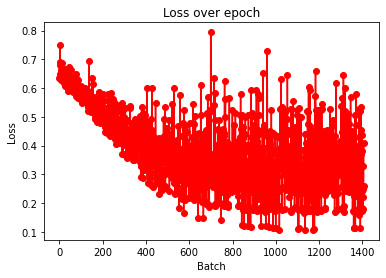

Epoch 2/20
-------------------------------
Starting model training...
Overall batches:  1407


Evaluating: 85it [01:46,  1.25s/it]


KeyboardInterrupt: 

In [14]:
seti_trainer = SETITrainValidation(conf_dict["train_dir"], conf_dict["test_dir"], load_model=False, use_backbone=False)
seti_trainer.split(behaviour=conf_dict["behaviours"]["all"], use_all=True)
seti_trainer.train_model()
# seti_trainer.validate_model()